<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/KDD_cup_ada_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import numpy as np
import pickle
from collections import OrderedDict

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import plot_corr_heatmap
from IPython.display import display, HTML

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
scorer  = {'f2_score': make_scorer(fbeta_score, beta=2)}

In [80]:
df_train = pd.read_csv('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train.data', sep='\t')

In [81]:
df_train.shape

(50000, 230)

In [82]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [83]:
df_test = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_test.data')
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,72.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4259232.0,NaN,NaN,...,NaN,xddq9ayfAo,RO12,NaN,taul,1K8T,PShj,iJzviRg,17VONbZnAuZ90atz,MF5EBmj,NaN,WVvO,9_Y1,vm5R,VpdQ,haYg,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,XREFJCi,NaN,7WwzJJY,OgPm,cJvF,FzaX,ch2oGfM,Al6ZaUT,P6pu4Vl,LM8l689qOp,NaN,ELof,7P5s,ZI9m,R4y5gQQWY8OodqDV,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,259.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,240.0,NaN,0.0,40.0,NaN,NaN,300.32,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4859550.0,NaN,NaN,...,NaN,cFHt0GoOh3,RO12,NaN,taul,1K8T,lK27,rsmctTK,7ONkRNQCK7,NaN,NaN,aFB2,9_Y1,t_4G,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,4ls8,cJvF,FzaX,Kgofc8E,oslk,S46Rt72,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,861.0,14.0,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,40.0,NaN,0.0,8.0,NaN,NaN,186.64,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,10038840.0,NaN,NaN,...,NaN,zcROj17IEC,RO12,NaN,taul,1K8T,oXaB,I6Bd3iM,bGUqwlz,NaN,NaN,6k5I,9_Y1,iVbl,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,0b0w,cJvF,FzaX,bBmOw16,oslk,CcdTy9x,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1568.0,7.0,NaN,NaN,NaN,NaN,NaN,1232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448.0,560.0,NaN,4.0,88.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,116760.0,NaN,NaN,...,NaN,gOyq9ayE15,2Knk1KF,SEuy,taul,1K8T,tzKK,Te2s8CN,hOpRIhsUSP,x0xpMjN,smXZ,kVZt,9_Y1,vm5R,VpdQ,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,3yoa8Yv,NaN,XTbPUYD,XqfQ,UYBR,AU8pNoi,rDm6pd1,oslk,Q53Rkup,LM8l689qOp,NaN,kG3k,7P5s,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,NaN
4,NaN,NaN,NaN,NaN,NaN,1197.0,7.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,125.0,NaN,8.0,40.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,257772.0,NaN,NaN,...,NaN,voArjIXt5a,onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890,NaN,taul,1K8T,80HR,fqeOwLG,nJy8d8N5V7yiy,IBmPo7a,NaN,oyu5,9_Y1,WIr3,VpdQ,kxE9,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,c02HCHI,NaN,_JdEa95,bOvW,cJvF,FzaX,fxJmel6,Al6ZaUT,WfsWw2A,LM8l689qOp,NaN,ELof,5Acm,ZI9m,iyHGyLCEkQ,am7c,NaN


In [84]:
y_train_appetency =pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
y_train_appetency.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [85]:
y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
y_train_upselling.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [86]:
y_train_churn = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

Change the lables from [-1, 1] to [0, 1]

In [87]:
y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [88]:
y_train_appetency.tail()

49995    1.0
49996    1.0
49997    0.0
49998    0.0
49999    0.0
Name: 0, dtype: float64

In [89]:
np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

(0.0178, 0.07344, 0.07364)

### Preprocessing

In [90]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [91]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [92]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


In [93]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [94]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [95]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


For now, let us drop all the categorical cols and float cols with >95% of data being null

In [96]:
categorical_cols = list(df_table[df_table['dtype']=='object'].index)
drop_cols = lst_empty_float_cols + categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 187


In [97]:
df_train_kdd = df_train.drop(drop_cols,axis=1)
df_train_kdd = df_train_kdd.fillna(df_train_kdd.mean())

In [98]:
df_train_kdd.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var51,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,43652.006725,4.076907,9.0,4.190659,36,35.0,1350864.0,0.0,7333.110000,5.0,12.0,98671.065858,104.00000,168.0,117625.60,1175.000000,6.0,720.0,8.00000,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,462.000000
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,43652.006725,5.408032,9.0,3.000000,26,0.0,2872928.0,3.0,151098.900000,25.0,2.0,58158.000000,40.00000,40.0,-356411.60,590.000000,72.0,0.0,-0.55388,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,270.142137
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,43652.006725,6.599658,9.0,4.190659,130,518.0,1675776.0,0.0,16211.580000,40.0,58.0,98671.065858,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,-28.00000,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,270.142137
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,43652.006725,1.988250,9.0,4.190659,12,0.0,0.0,0.0,103084.052693,0.0,0.0,98671.065858,60.88866,0.0,-275703.60,916.112185,0.0,0.0,-14.00000,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,270.142137
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,43652.006725,4.552446,18.0,3.000000,82,224.0,784448.0,0.0,37423.500000,0.0,0.0,89754.000000,32.00000,56.0,10714.84,215.000000,0.0,15111.0,58.00000,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,270.142137


In [102]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp37-none-any.whl size=10670 sha256=845fda0903f984a430a0aefd09d1b724787b1ab26739f110a0383d4ee6d7a469
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp


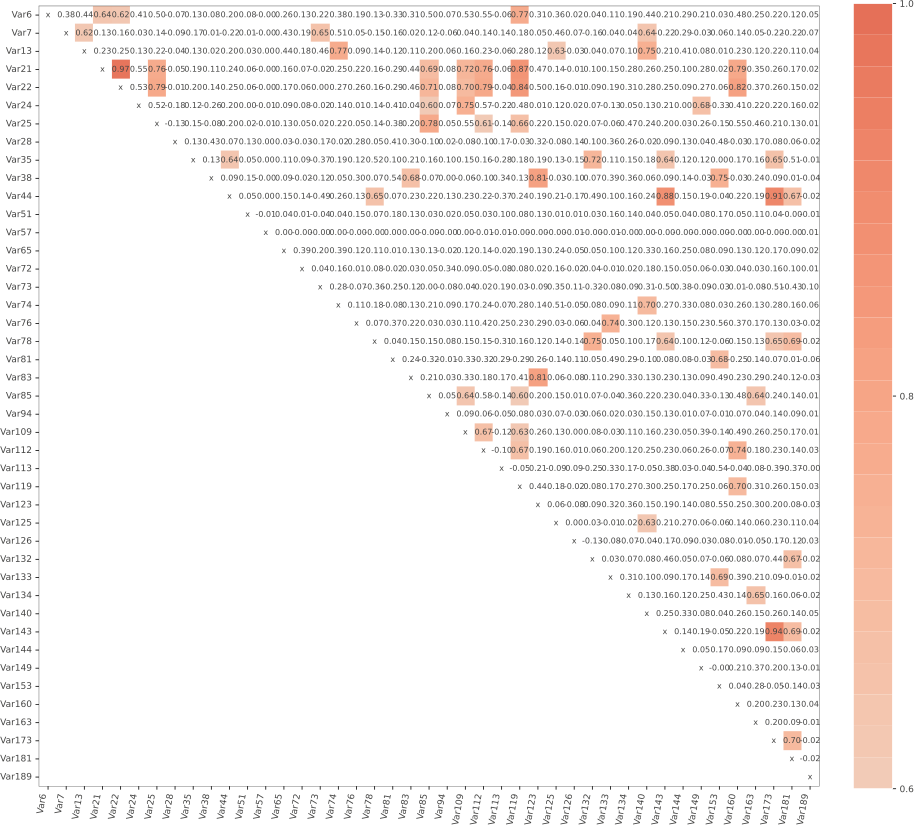

In [115]:
viz = plot_corr_heatmap(df_train_kdd, figsize=(13, 13))
viz

In [119]:
high_corr_cols = ['Var21', 'Var143', 'Var173']
df_train_kdd.drop(high_corr_cols, axis=1, inplace=True)

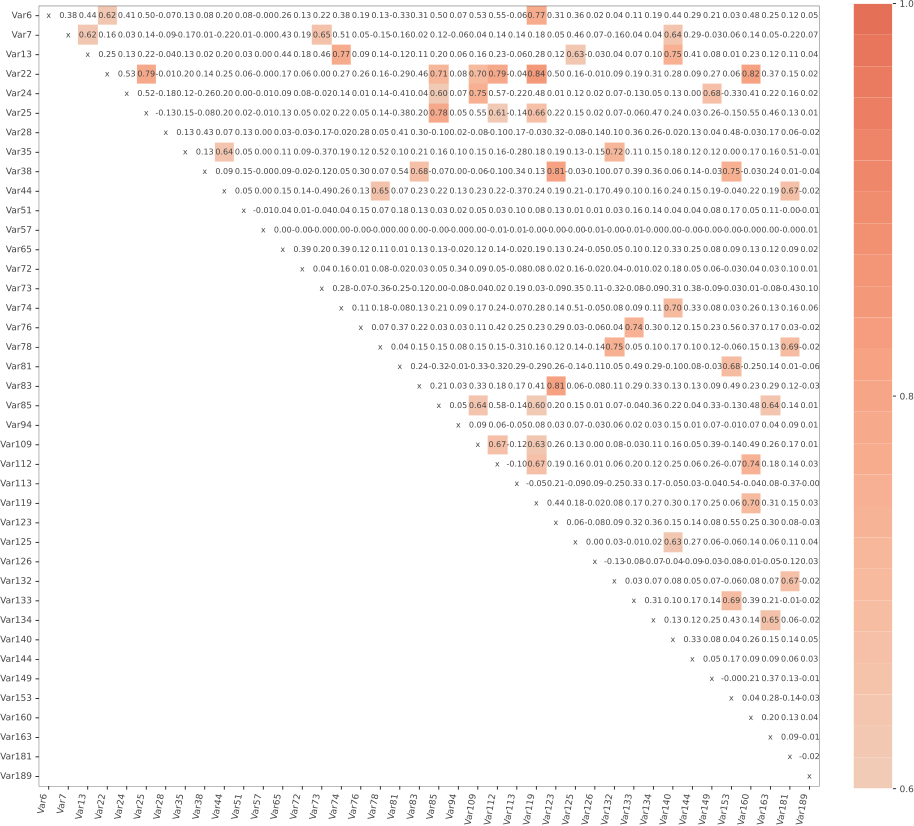

In [120]:
viz = plot_corr_heatmap(df_train_kdd, figsize=(13, 13))
viz

In [138]:
len(df_train_kdd[df_train_kdd['Var13'] > 30000])

42

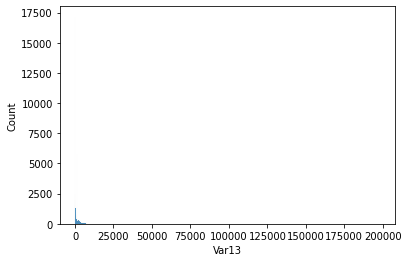

In [136]:
sns.histplot(df_train_kdd['Var13'])

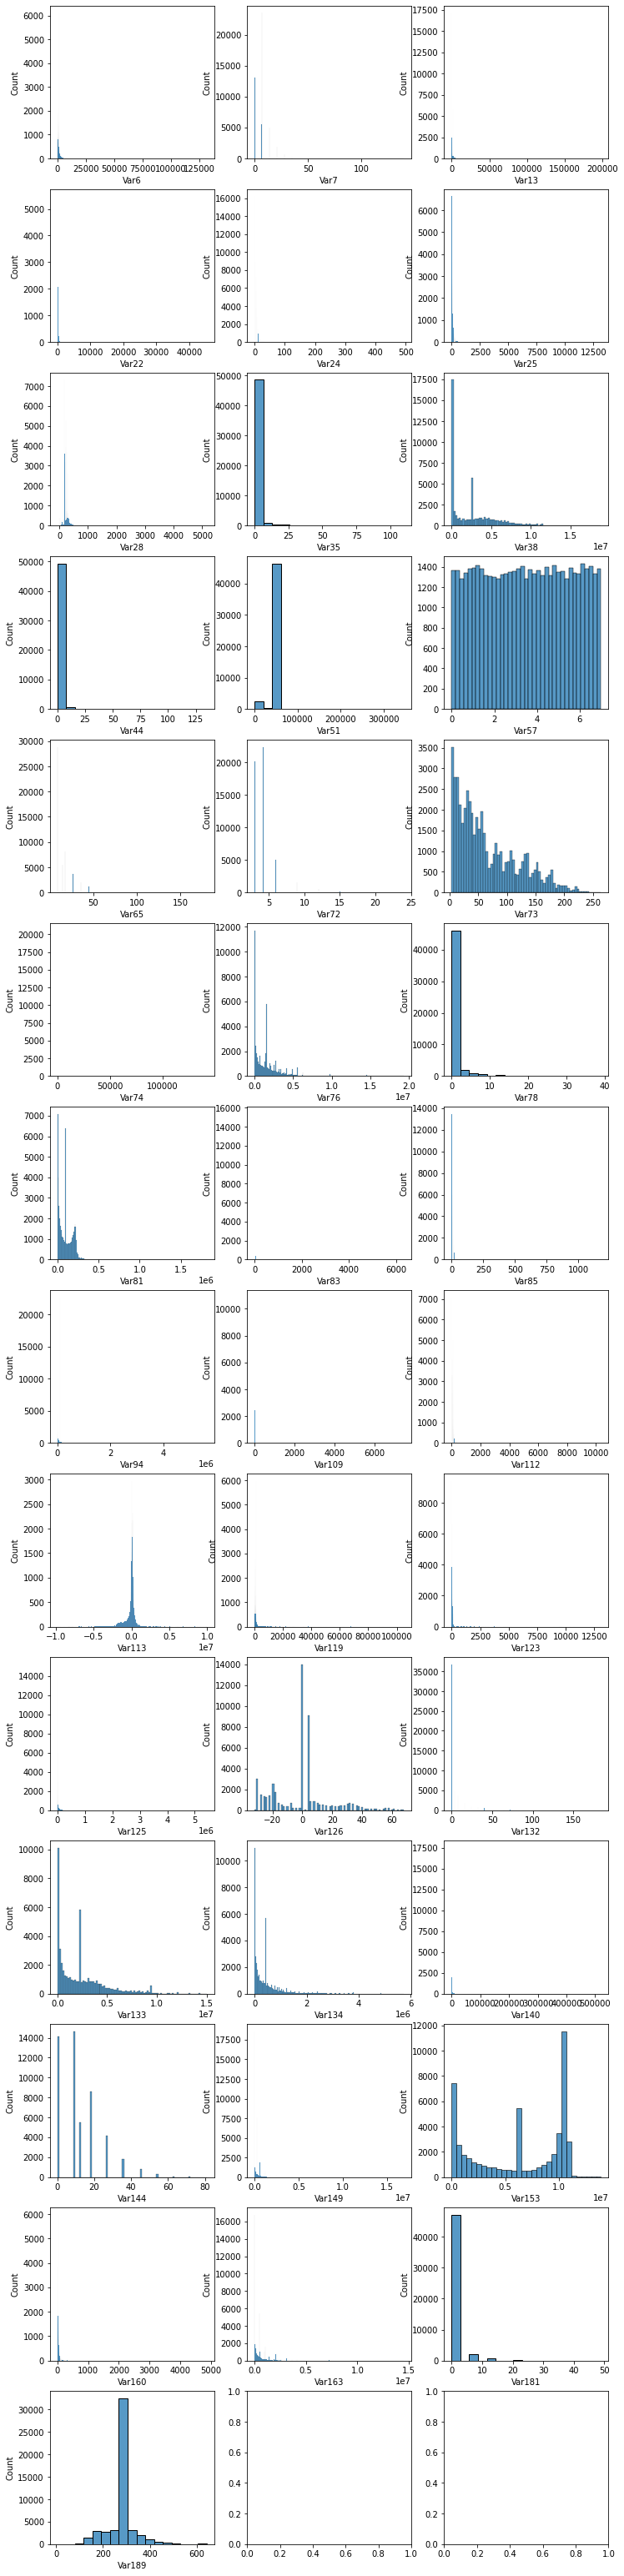

In [123]:
import math
ncols = 3
nrows = math.ceil(len(df_train_kdd.columns)/ncols)
fig, axen = plt.subplots(nrows, ncols, figsize = (12, nrows*4))
for v, ax in zip(df_train_kdd.columns, axen.ravel()):
    sns.histplot(df_train_kdd[v], ax=ax)

In [ ]:
X_train, y_train = df_train_kdd, y_train_churn

**All customers churn, we send everyone**

In [28]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

In [29]:
def do_classify(clf, parameters, df, 
                featurenames, 
                score_func, n_folds=5, n_jobs=1):
    # x test and ytest
    Xtrain= df
    ytrain= y_train
    # if not mask:
    #     print("using reuse split")
    #     Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'][featurenames], reuse_split['Xtest'][featurenames], reuse_split['ytrain'], reuse_split['ytest']
    # else: # mask is to be used
    #     print("using mask")
    #     Xtrain, Xtest, ytrain, ytest = X[reuse_split], X[~reuse_split], y[reuse_split], y[~reuse_split]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    # test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict 0.5 ################")
    print("F2 score on training data: %0.2f" % (training_accuracy))
    # print("Accuracy on test data:     %0.2f" % (test_accuracy))
    # print(confusion_matrix(ytest, clf.predict(Xtest)))
    # print("########################################################")
    # return clf, dict(Xtrain=Xtrain, ytrain=ytrain, Xtest=Xtest, ytest=ytest)

In [30]:
pure_cat_vars = []
cont_vars = X_train.columns

In [31]:
# set up standardization
ss = StandardScaler()
# oe hot encoding
oh = OneHotEncoder()
# continuous variables need to be standardized
cont_pipe = Pipeline([("scale", ss)])
# categorical variables need to be one hot encoded
cat_pipe = Pipeline([('onehot', oh)])
# combine both into a transformer
transformers = [('cont', cont_pipe, cont_vars)]
# apply transformer to relevant columns. Nothing will be done for the rest
ct = ColumnTransformer(transformers=transformers, remainder="passthrough")
# create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe = Pipeline(steps=[('ct', ct), ('model', LogisticRegression(max_iter=10000, penalty='l2'))])
# in paramgrid we dont use C but use model__C corresponding to the name in the pipeline
paramgrid = dict(model__C=[1000, 100, 10, 1, 0.1, 0.01, 0.001])

In [32]:
from sklearn.metrics import roc_auc_score
do_classify(pipe, paramgrid, X_train, 
                              cont_vars, 
                              score_func=scorer)

SCORE FUNC {'f2_score': make_scorer(fbeta_score, beta=2)}


ValueError: ignored

In [ ]:
# do_classify(clf, parameters, indf, 
#                 featurenames, targetname, target1val, 
#                 reuse_split, mask=False, 
#                 score_func=None, n_folds=5, n_jobs=1)

In [33]:
# Table report after dropping columns and filling na with 0
pretty_print(tbl_report(df_train_kdd, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])) 

Table Shape (50000, 43)


,dtype,nulls,num_uniques,value_counts
Var6,float64,0,1487,HC
Var7,float64,0,9,7.0:235300.0:130906.809495962753874:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var13,float64,0,2635,HC
Var21,float64,0,735,HC
Var22,float64,0,736,HC
Var24,float64,0,94,HC
Var25,float64,0,272,HC
Var28,float64,0,4168,HC
Var35,float64,0,14,HC
Var38,float64,0,30833,HC


# Random Forest

In [146]:
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.25, 0.3, 0.35]
)

In [142]:
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, max_features=15, n_jobs=-1)

In [143]:
# rf, _  = do_classify(rf, {"model__max_features": [0.2, 0.25, 0.3, 0.35]},
#     X_train, X_train.columns, score_func=scorer)

In [148]:
feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestClassifier(oob_score=True, max_features=label, n_jobs=-1, warm_start=True)
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

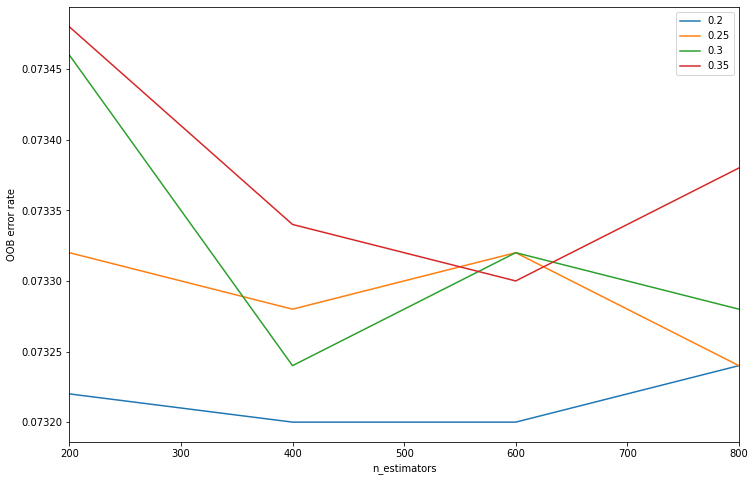

In [149]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
fig, ax = plt.subplots(figsize=(12, 8))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    ax.plot(xs, ys, label=label)

ax.set_xlim(min_estimators, max_estimators)
ax.set_xlabel("n_estimators")
ax.set_ylabel("OOB error rate")
ax.legend(loc="upper right")

In [150]:
print(error_rate)

OrderedDict([(0.2, [(200, 0.07321999999999995), (400, 0.07320000000000004), (600, 0.07320000000000004), (800, 0.07323999999999997)]), (0.25, [(200, 0.07332000000000005), (400, 0.07328000000000001), (600, 0.07332000000000005), (800, 0.07323999999999997)]), (0.3, [(200, 0.07345999999999997), (400, 0.07323999999999997), (600, 0.07332000000000005), (800, 0.07328000000000001)]), (0.35, [(200, 0.07347999999999999), (400, 0.07333999999999996), (600, 0.07330000000000003), (800, 0.07338)])])


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
param_grid = {'min_samples_leaf': [5, 8],  ## depends on the num of training examples
              'max_features': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
              }

In [ ]:
gb_3000 = GradientBoostingClassifier(n_estimators=3000, max_depth=5)
clf_gb = GridSearchCV(gb_3000, param_grid, cv=3, n_jobs=-1)

In [ ]:
clf_gb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=5,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=3000,
                                                  n_iter_no_change=None,
        

In [ ]:
clf_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=0.35, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=8, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradient_boosting_3000.pickle'

In [ ]:
pickle.dump(clf_gb.best_estimator_, open(filename, 'wb'))

In [ ]:
# Read the file
# clf_gb = pickle.load(open(filename, 'rb'))

In [ ]:
clf_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=0.35, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=8, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
best_gb_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=0.35, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=8, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None,  tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False, subsample=0.7)

In [ ]:
best_gb_model.fit(df_train_kdd, y_train_churn)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=0.35, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=8, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
best_gb_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradient_boosting_best_3000_with_ss.pickle'
pickle.dump(best_gb_model, open(best_gb_filename, 'wb'))

In [ ]:
best_gb_model = pickle.load(open(best_gb_filename, 'rb'))

In [ ]:
def deviance_plot_for_gb(est, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    oob_dev = est.oob_improvement_

    # print(test_dev)
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 8))
        
    ax.plot(np.arange(n_estimators) + 1, oob_dev, color=test_color, label='oob set %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train set %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('oob_error')
    ax.set_xlabel('n_estimators')
    # ax.set_ylim(ylim)
    return oob_dev, ax

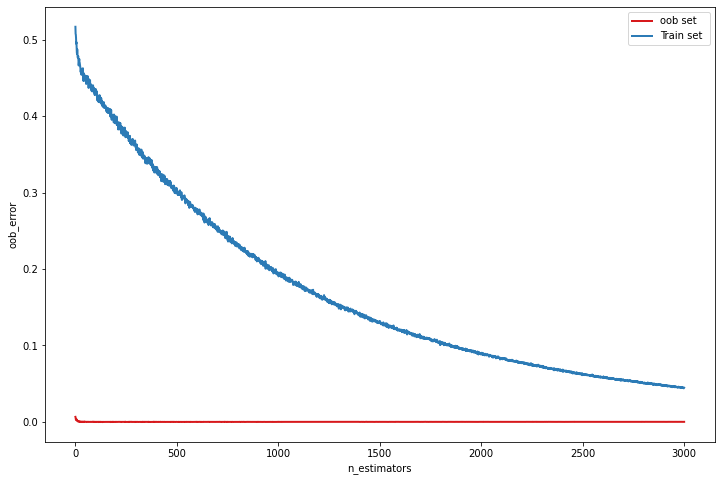

In [ ]:
deviance_plot_for_gb(best_gb_model)
plt.legend()
plt.show()

In [ ]:
df_train_kdd.shape

(50000, 43)

In [ ]:
precision, recall, tresholds = precision_recall_curve(y_train_churn, best_gb_model.predict_proba(df_train_kdd)[:,1])

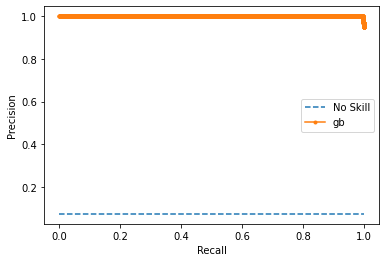

In [ ]:
no_skill = len(y_train_churn[y_train_churn==1]) / len(y_train_churn)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='gb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# Ada Boosting

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
param_grid = {'n_estimators': range(100, 1000, 300), 'learning_rate':[0.001, 0.01, 0.1]}

In [66]:
# Performing train-val split since AdaBoostClassifier does not provide oob score
X_train_ab, X_val_ab, y_train_ab, y_val_ab = train_test_split(X_train, y_train, random_state=66, train_size=0.8, stratify=y_train) 

In [67]:
ab = AdaBoostClassifier()
clf_ab = GridSearchCV(ab, param_grid, cv=3, n_jobs=-1)

In [68]:
clf_ab.fit(X_train_ab, y_train_ab)

GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': range(100, 1000, 300)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [69]:
filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/adaboost_best_lr.pickle'
pickle.dump(clf_ab.best_estimator_, open(filename, 'wb'))

In [70]:
clf_ab.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=100, random_state=None)

In [71]:
adaboost_clf = clf_ab.best_estimator_
y_val_pred = adaboost_clf.predict_proba(X_val_ab)

In [72]:
precision, recall, thresholds = precision_recall_curve(y_val_ab, y_val_pred[:,1])

In [73]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.100365, F-Score=0.167


In [74]:
max(fscore)

0.1666252176075603

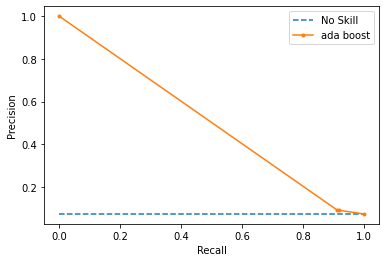

In [76]:
no_skill = len(y_val_ab[y_val_ab==1]) / len(y_val_ab)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='ada boost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()